Import libraries

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set_style("whitegrid", {"axes.grid" : False})
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("muted")

Load the training and testing set

In [95]:
training_set  = pd.read_csv("dataset/train.csv")
testing_set = pd.read_csv("dataset/test.csv")

In [96]:
training_set.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [97]:
testing_set.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [98]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [99]:
training_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [100]:
testing_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

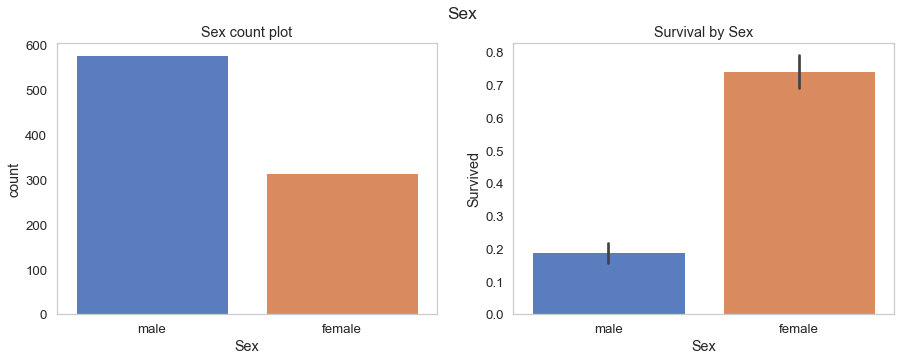

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle("Sex")

sns.countplot(ax=axes[0], x="Sex", data=training_set)
axes[0].set_title("Sex count plot")

sns.barplot(ax=axes[1], x="Sex", y="Survived", data=training_set)
axes[1].set_title("Survival by Sex");

Impute missing data in embarked column

In [102]:
training_set.groupby("Embarked").size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [103]:
training_set_copy = training_set.copy()
testing_set_copy = testing_set.copy()

In [104]:
training_set_copy["Embarked"].fillna("S", inplace=True)

In [105]:
imputer = KNNImputer(n_neighbors=3)
training_set_copy["Age"] = imputer.fit_transform(training_set_copy[["Age"]]).ravel()
testing_set_copy["Age"] = imputer.fit_transform(testing_set_copy[["Age"]]).ravel()
testing_set_copy["Fare"] = imputer.fit_transform(testing_set_copy[["Fare"]]).ravel()

In [106]:
drop_column = ["PassengerId", "Name", "Cabin", "Ticket"]
training_set_copy = training_set_copy.drop(drop_column, axis=1)
testing_set_copy = testing_set_copy.drop(drop_column, axis=1)

In [107]:
training_set_copy.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [108]:
testing_set_copy.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [109]:
training_set_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [110]:
label_encoder = LabelEncoder()
training_set_copy["Sex"] = label_encoder.fit_transform(training_set_copy["Sex"])
training_set_copy["Embarked"] = label_encoder.fit_transform(training_set_copy["Embarked"])
testing_set_copy["Sex"] = label_encoder.fit_transform(testing_set_copy["Sex"])
testing_set_copy["Embarked"] = label_encoder.fit_transform(testing_set_copy["Embarked"])

In [111]:
X_train = training_set_copy.drop(["Survived"], axis=1)
y_train = pd.DataFrame(training_set_copy["Survived"].copy())
X_test = testing_set_copy

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [113]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("Naive Bayesian", GaussianNB()),
    ("Support Vector Machine", SVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier())]

results = []
names = []
scoring = "accuracy"
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.3f}, {cv_results.std():.3f}")

Logistic Regression: 0.792, 0.029
KNN: 0.798, 0.032
Naive Bayesian: 0.789, 0.023
Support Vector Machine: 0.826, 0.044
Decision Tree: 0.776, 0.029
Random Forest: 0.806, 0.030


## Fine Tuning

In [114]:
clf = SVC()

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 10, random_state = 42, scoring = "accuracy") 
rand_search.fit(X_train, y_train.values.ravel()) 
rand_search.best_params_

{'C': 5.046137691733707, 'gamma': 0.19767211400638388}

In [115]:
y_train_predicted = rand_search.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_predicted)
y_train_accuracy

0.8597081930415263

Classification report

In [125]:
clf_report = classification_report(y_train, y_train_predicted)
print(clf_report)

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       549
           1       0.91      0.70      0.79       342

    accuracy                           0.86       891
   macro avg       0.88      0.83      0.84       891
weighted avg       0.87      0.86      0.86       891



In [126]:
conf_matrix = confusion_matrix(y_train, y_train_predicted)
print(conf_matrix)

[[526  23]
 [102 240]]


Predict the test set

In [121]:
y_test_predicted = rand_search.predict(X_test)
survival_predicted = pd.DataFrame(y_test_predicted)